<a href="https://colab.research.google.com/github/gmihaila/gtc2020_instructor_training/blob/master/content/sentiment_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 George Mihaila.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# GPUs in Natural Language Processing


<td>
    <a target="_blank" href="https://colab.research.google.com/github/gmihaila/gtc2020_instructor_training/blob/master/sentiment_clustering.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
<td>
  <a target="_blank" href="https://github.com/gmihaila/gtc2020_instructor_training.git"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</br>

The main purpose of this tutorial is to target a particular Natural Language Processing (NLP) problem, in this case Sentiment Analysis, and use GPUs for great speedup.

Walkthoughs:

### Datasets used:
* [IMDB moview reviews sentiment dataset](http://ai.stanford.edu/%7Eamaas/data/sentiment/): This is a dataset for binary sentiment classification containing a set of **25,000** highly polar movie reviews for training, and **25,000** for testing. For this tutorial we will combine the train and test data for a total of **50,000 movies reviews** text data and their negative/positive labels.

* [Yelp Dataset Challenge](https://www.yelp.com/dataset/challenge):Natural Language Processing & Sentiment Analysis purpose from reviews of restaurants and bussinsess. Dataset used in this tutorial **yelp_academic_dataset_review.pickle** which contains around **1.5M** reviews. For each review we have a rating from 1-5 which reflect users satisfaction. [GitHub](https://github.com/titipata/yelp_dataset_challenge). 
 
 **NOTE:** *To obtain the dataset, please follow this link:* **https://www.yelp.com/dataset/download**


### Content:

 * Use Sentence Embeddings from pretrained state of the art language models, in this case **bert-base-nli-stsb-mean-tokens**, to transform text data data into fixed vector feratures of length **768 features**. Performing model inference using GPU.
 * Use GPU to perform kmeans clustering on all 50,000 movies reviews.
 * Find the best splitting K using the Elbow method and Silhouette score.
 * Use k=2 on kmeans and plot the sentiments on both predicted clusters and true labels.
 * Observe the overlap between the predcited labels and true labels and asociate labels to clusters. Visualize the clusters.
 * Try to find a third sentiment using k=3. Observe the overlab between predicted labels and true labels. Visualize the clusters.
 * Repeat previous experiments using different k and observe predicitons overlp with true labels. Visualize the clusters.
 * Visualize samples of text that are predicted with various sentiments.
 * Repeat Similar experiemtns on the Yelp Dataset.


## NLP - Fine-grained Sentiment Analysis

For most cases sentiment classifiers are used in binary classification (just positive or negative sentiment). That is because fine-grained sentiment classification is a significantly more challenging task! 

The typical breakdown of fine-grained sentiment uses five discrete classes, as shown below. As one might imagine, models very easily err on either side of the strong/weak sentiment intensities thanks to the wonderful subtleties of human language.

![alt text](https://miro.medium.com/max/705/1*ug8kyqUlnqEuo3LhHfNypg.png)

Binary class labels may be sufficient for studying large-scale positive/negative sentiment trends in text data such as Tweets, product reviews or customer feedback, but they do have their limitations. 

When performing information extraction with comparative expressions, for example: 
 * “This OnePlus model X is so much better than Samsung model X.” 
  * a fine-grained analysis can provide more precise results to an automated system that prioritizes addressing customer complaints. 

 * “The location was truly disgusting ... but the people there were glorious.” 
  * dual-polarity sentences can confuse binary sentiment classifiers, leading to incorrect class predictions.

[source](https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4)



## Notebook Environment Sanity Check

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4 or P100.

[source](https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=scfLT2i0MLyD)

In [0]:
## VERSION CHECK
!nvidia-smi
!nvcc -V
!python -V; pip -V

Wed Feb 12 04:52:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Installs

* [Sentence-Transformers](https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=scfLT2i0MLyD): wrapper around Hugging Face [transformers](https://github.com/huggingface/transformers) library and built for document embedding using state of the art language models like BERT or XLNET.

* Set up script installs for [Rapids](https://rapids.ai):

  1. Install most recent Miniconda release compatible with Google Colab's Python install  (3.6.7)
  1. removes incompatible files
  1. Install RAPIDS libraries
  1. Set necessary environment variables
  1. Copy RAPIDS .so files into current working directory, a workaround for conda/colab interactions
  1. Recommend select v0.10.

In [1]:
import sys, os
from IPython.display import clear_output

# install sentence transfomers
!pip install git+https://github.com/arvkevi/kneed # for graph knee detection
!pip install git+https://github.com/UKPLab/sentence-transformers
clear_output(wait=True)

# Install RAPIDS
!rm rapids-colab.sh
!wget -nc https://raw.githubusercontent.com/rapidsai/notebooks-contrib/890b04ed8687da6e3a100c81f449ff6f7b559956/utils/rapids-colab.sh
!bash rapids-colab.sh

dist_package_index = sys.path.index("/usr/local/lib/python3.6/dist-packages")
sys.path = sys.path[:dist_package_index] + ["/usr/local/lib/python3.6/site-packages"] + sys.path[dist_package_index:]
sys.path
if os.path.exists('update_pyarrow.py'): ## This file only exists if you're using RAPIDS version 0.11 or higher
  exec(open("update_pyarrow.py").read(), globals())

clear_output(wait=True)

--2020-02-12 07:31:01--  https://raw.githubusercontent.com/rapidsai/notebooks-contrib/890b04ed8687da6e3a100c81f449ff6f7b559956/utils/rapids-colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5286 (5.2K) [text/plain]
Saving to: ‘rapids-colab.sh’

rapids-colab.sh     100%[===================>]   5.16K  --.-KB/s    in 0s      

2020-02-12 07:31:01 (101 MB/s) - ‘rapids-colab.sh’ saved [5286/5286]

PLEASE READ
********************************************************************************************************
Colab v0.11+ Migration Notice:
 
There has been a NECESSARY Colab script code change for VERSION 0.11+ that MAY REQUIRE an update how you install RAPIDS into Colab!  
Not all Colab notebooks are updated (like personal Colabs) and while the script will i

### Downloads

In [0]:
if not os.path.exists('imdb_reviews_all_labeled.csv'):
  # IMDB movie reviews
  !wget https://github.com/gmihaila/gtc2020_instructor_training/raw/master/data/imdb_reviews_all_labeled.csv
if not os.path.exists('yelp_academic_dataset_review.pickle'):
  # yelp reviews
  !wget https://s3-us-west-2.amazonaws.com/science-of-science-bucket/yelp_academic_dataset/yelp_academic_dataset_review.pickle

### Imports

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import torch
## Load TF 2.0
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sentence_transformers import SentenceTransformer
import cudf
from cuml import KMeans
from cuml import PCA as cuPCA
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords 
import nltk

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

os.environ['NUMBAPRO_NVVM']='/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so'  
os.environ['NUMBAPRO_LIBDEVICE']='/usr/local/cuda-10.0/nvvm/libdevice'

ID_SENTIMENT = {0:'Negative',
                1:'Positive'}

PRETRAINED_MODEL = 'bert-base-nli-stsb-mean-tokens'

TensorFlow 2.x selected.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Functions

In [0]:
def read_yelp_reviews(filename):
  tmp_df = pd.read_pickle(filename)
  yelp_reviews_texts = tmp_df['text'].values
  yelp_reviews_stars = tmp_df['stars'].values
  return yelp_reviews_texts, yelp_reviews_stars


def context_embedding(text, name_of_model, batch_size=1000, use_device="cuda"):
  embed_model = SentenceTransformer(model_name_or_path=name_of_model,
                                    device=torch.device(use_device))
  encodings_text = embed_model.encode(sentences=text, 
                                          batch_size=batch_size, 
                                          show_progress_bar=True)
  # empty GPU cache
  torch.cuda.empty_cache()
  return  np.array(encodings_text)


def best_kmeans_elbow(features, n_clusters, verbose=False, show=False):
  features = cudf.DataFrame.from_gpu_matrix(features)
  # features = np.array(features)
  
  clusters = list(range(2, n_clusters))
  distortions = []

  for n_clusters in clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(features)
    
    distortion = kmean_model.inertia_
    distortions.append(distortion)

    if verbose: print("For n_clusters =", n_clusters, "Distortion is :", distortion)

  kn = KneeLocator(clusters, distortions, curve='convex', direction='decreasing')
  best_k = int(kn.knee)

  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      distortions,
                      color="coral", 
                      label="Distortions")
  plot.set(xlabel='k', ylabel='Distortions')
  plot.set_title('Using Elbow method for best k')
  plot.axvline(x=best_k)
  if show: plt.show()
  fig = plot.get_figure()
  fig.savefig("elbow_distortions.png")
  return



def best_kmeans_silhouette(features, n_clusters):
  features = np.array(features)
  
  clusters = list(range(2, n_clusters))
  silhouettes = []

  for n_clusters in clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(np.array(features))

    cluster_labels = kmean_model.predict(features)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouettes.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

  best_k = clusters[silhouettes.index(max(silhouettes))]

  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      silhouettes,
                      color="coral", 
                      label="Silhouette Average Score")
  plot.set(xlabel='k', ylabel='Silhouette Average Score')
  plot.set_title('Silhouette Average Score for each cluster k')
  plot.axvline(x=best_k)
  fig = plot.get_figure()
  fig.savefig("silhouette_avg.png")
  return


def kmeans(k, features):
  features = cudf.DataFrame.from_gpu_matrix(features)
  kmean_model = KMeans(n_clusters=k)
  kmean_model.fit(features)
  labels = kmean_model.labels_
  return labels, kmean_model



def pca_reduction(features, labels_values, n_components, random_state=20, 
                  label_decoder=None, title='PCA Plot', magnify=2):
  # move to GPU matrix
  features = cudf.DataFrame.from_gpu_matrix(features)
  pca_cuml = cuPCA(n_components=n_components,
                   random_state=random_state)
  # pca_cuml.fit(features)
  # reduced_features = pca_cuml.transform(gdf_float)
  reduced_features = pca_cuml.fit_transform(features)

  # plot
  if (n_components==2) and (labels_values is not None):
    # create data frame
    reduced_features_df = pd.DataFrame()
    reduced_features_df['x'] = [float(value) for value in reduced_features.values[:,0]]
    reduced_features_df['y'] = [float(value) for value in reduced_features.values[:,1]]
    if label_decoder is not None:
      reduced_features_df['clusters'] = [label_decoder[int(value)] for value in labels_values]
    else:
      reduced_features_df['clusters'] = [int(value) for value in labels_values]
    #plot data with seaborn
    cluster_plot = sns.lmplot(data=reduced_features_df, x='x', y='y', hue='clusters', fit_reg=False, legend=True, legend_out=True)
    plt.title(title)
    fig = plt.gcf()
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
    cluster_plot.savefig("pca_plot.png")
  return reduced_features.values


def predictions_overlap(model_predicitons, true_predicitons, label_decoder):
  labels = list(set(model_predicitons))
  print("Found labels: %s\n" % labels)
  ## dicitonary with predicitons counts clusters
  predictions = {label:[] for label in labels}
  for true_label, pred_label in zip(true_predicitons, model_predicitons):
    predictions[pred_label].append(true_label)
  # data frame
  matching_df = pd.DataFrame()
  matching_df['labels'] = labels
  matching_df['cluster_match'] = ["  ".join([str(label_decoder[cluster])+":"+str(count) for cluster, count in Counter(predictions[label]).most_common()]) for label in labels]
  return matching_df


def show_samples(target_predicitons_class, texts, predicitons, trues, trues_id_sentiment,
                 predictions_id_sentiment, n_samples):
  samples_texts = []
  samples_labels = []

  while len(samples_texts) < n_samples:
    pick = np.random.randint(low=0, high=(len(trues)-1))
    if predicitons[pick] == target_predicitons_class:
      samples_texts.append(texts[pick])
      samples_labels.append(trues[pick])

  samples_df = pd.DataFrame()
  samples_df['Text'] = samples_texts
  samples_df['Label Sentiment'] = [trues_id_sentiment[label] for label in samples_labels]
  samples_df['Prediction Sentiment'] = [predictions_id_sentiment[target_predicitons_class] for _ in samples_labels]
  return samples_df

def custom_sample(text, model, prediction_id_label):
  text_embedding = context_embedding(text=[text], 
                                      name_of_model=PRETRAINED_MODEL, 
                                      batch_size=1, use_device="cuda")
  prediction_label = model.predict(np.array(text_embedding))
  return prediction_id_label[prediction_label[0]]

def read_news_data(filename, verbose=False):
  news_contents = []
  with gzip.open(filename, "rb") as f:
    for index, line in enumerate(f, start=1):
      entry = json.loads(line.decode())      
      news_contents.append(entry['content'])
      if (index%50000==0) and verbose:
        print(index)
  return news_contents


def clusters_words_plot(texts, labels, n_sentiments, pos_tag, top_clip=0, low_clip=20, stop_words=None, magnify=2):
  # low_clip and top_clip are clips of the most frequent words to show
  # pos_tag in ['VB', 'NN']
  labels_texts = {n:[] for n in range(n_sentiments)}
  for text, label in zip(texts, labels):
    labels_texts[label].append(text)
  for sentiment in range(n_sentiments):
    # fit tokenizer on texts
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts=labels_texts[sentiment])
    top_words = list(tokenizer.word_index.keys())
    if pos_tag is not None: 
      top_words = nltk.pos_tag(tokens=top_words)
      top_words = [val[0] for val in top_words if val[1]==pos_tag]
    if stop_words is not None: top_words=[word for word in top_words if word not in stop_words]
    # temporary Data Frame
    tmp_df = pd.DataFrame()
    tmp_df['words'] = top_words[top_clip:low_clip]
    tmp_df['count'] = [tokenizer.word_counts[word] for word in top_words[top_clip:low_clip]]
    # plot
    ax = sns.barplot(x='words', y='count', data=tmp_df)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large')
    fig = plt.gcf()
    ax.set_title('Words Counts Sentimen %s'%sentiment)
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
  return

# IMDB Reviews

## Dataset

In [5]:
movies_sentiments_df = pd.read_csv('imdb_reviews_all_labeled.csv')

movies_reviews = movies_sentiments_df['reviews'].values
sentiments_reviews = movies_sentiments_df['sentiments'].values

print(movies_reviews[:2])
print(sentiments_reviews[:2])
print(len(sentiments_reviews))

["This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was

## Embeddings

In [6]:
movies_reviews_embeddings = context_embedding(text=movies_reviews, name_of_model=PRETRAINED_MODEL, batch_size=500, use_device="cuda")

Batches: 100%|██████████| 100/100 [06:37<00:00,  8.95s/it]


## Find Best k-means

In [0]:
max_n_cluster = 10

### Elbow Method

For n_clusters = 2 Distortion is : 4172841.5
For n_clusters = 3 Distortion is : 4053103.75
For n_clusters = 4 Distortion is : 3978636.5
For n_clusters = 5 Distortion is : 3931935.5
For n_clusters = 6 Distortion is : 3888730.75
For n_clusters = 7 Distortion is : 3859650.5
For n_clusters = 8 Distortion is : 3831165.5
For n_clusters = 9 Distortion is : 3805345.25


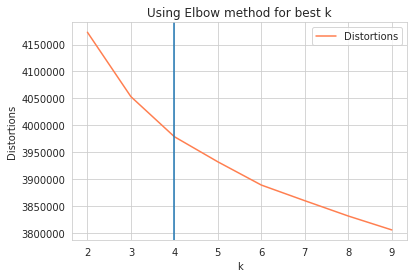

In [9]:
best_kmeans_elbow(features=movies_reviews_embeddings, n_clusters=max_n_cluster, verbose=True)

### Silhouette Method [time consuming]

For n_clusters = 2 The average silhouette_score is : 0.03998012
For n_clusters = 3 The average silhouette_score is : 0.03486097
For n_clusters = 4 The average silhouette_score is : 0.03242191
For n_clusters = 5 The average silhouette_score is : 0.03142608
For n_clusters = 6 The average silhouette_score is : 0.020849094
For n_clusters = 7 The average silhouette_score is : 0.01837415
For n_clusters = 8 The average silhouette_score is : 0.017937498
For n_clusters = 9 The average silhouette_score is : 0.016972205


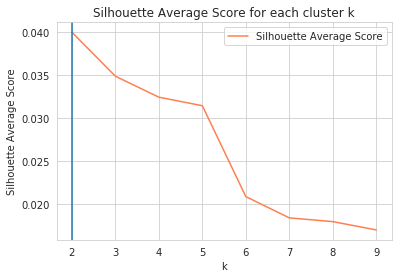

In [0]:
# best_kmeans_silhouette(features=movies_reviews_embeddings, n_clusters=max_n_cluster)

### Best K model

In [0]:
best_k = 2

best_kmeans_labels, _ = kmeans(k=best_k, features=np.array(movies_reviews_embeddings))

### PCA Visualize

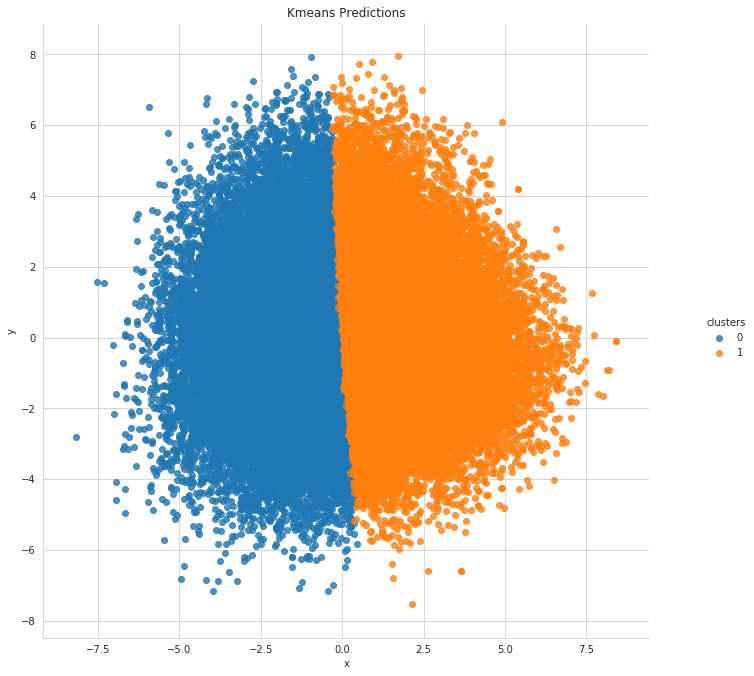

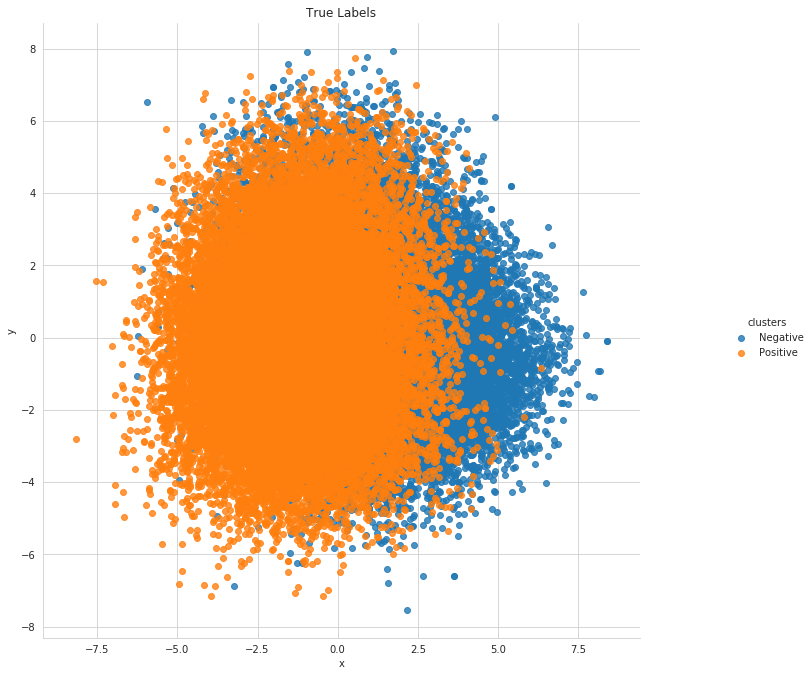



Found labels: [0, 1]



labels                  cluster_match
0  0       Positive:19310  Negative:6693
1  1       Negative:18307  Positive:5690

In [15]:
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=best_kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=None,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=sentiments_reviews, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')

print('\n')
matching_df = predictions_overlap(model_predicitons=best_kmeans_labels, 
                                  true_predicitons=sentiments_reviews,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

## K Means Sentiments

### k=3 sentiments

In [0]:
k_sentiments = 3

#### Fit kmeans

In [0]:
kmeans_labels, kmean_model = kmeans(k=k_sentiments, features=np.array(movies_reviews_embeddings))

#### Find Labels

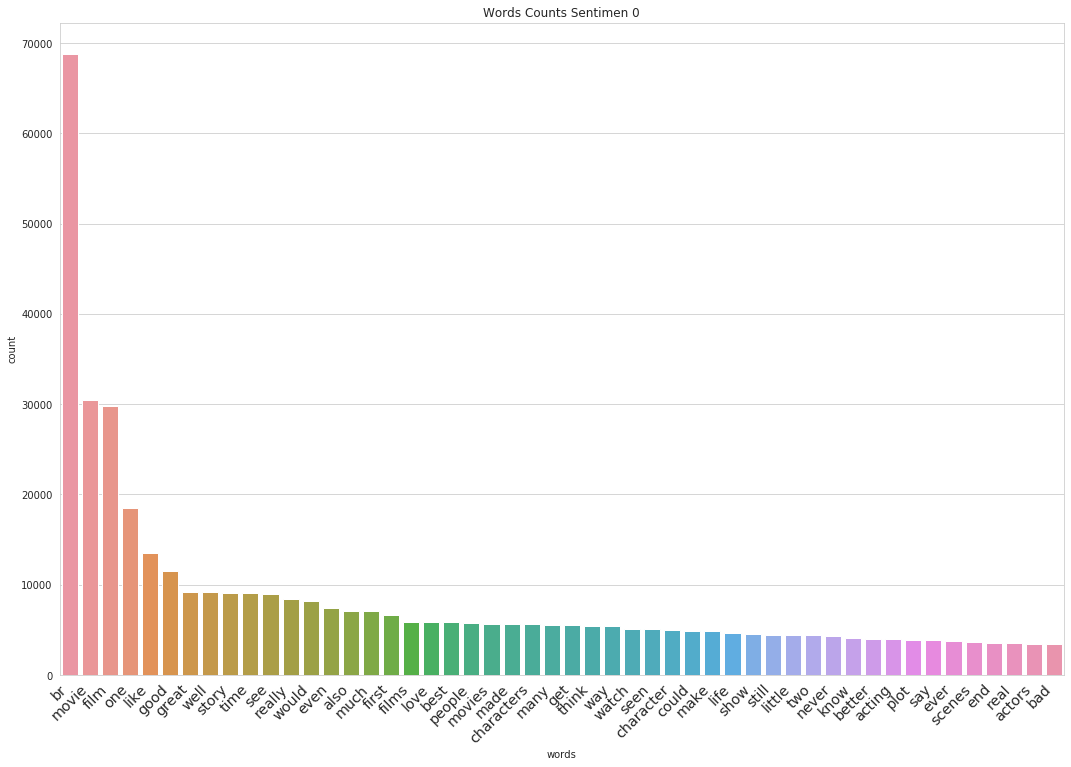

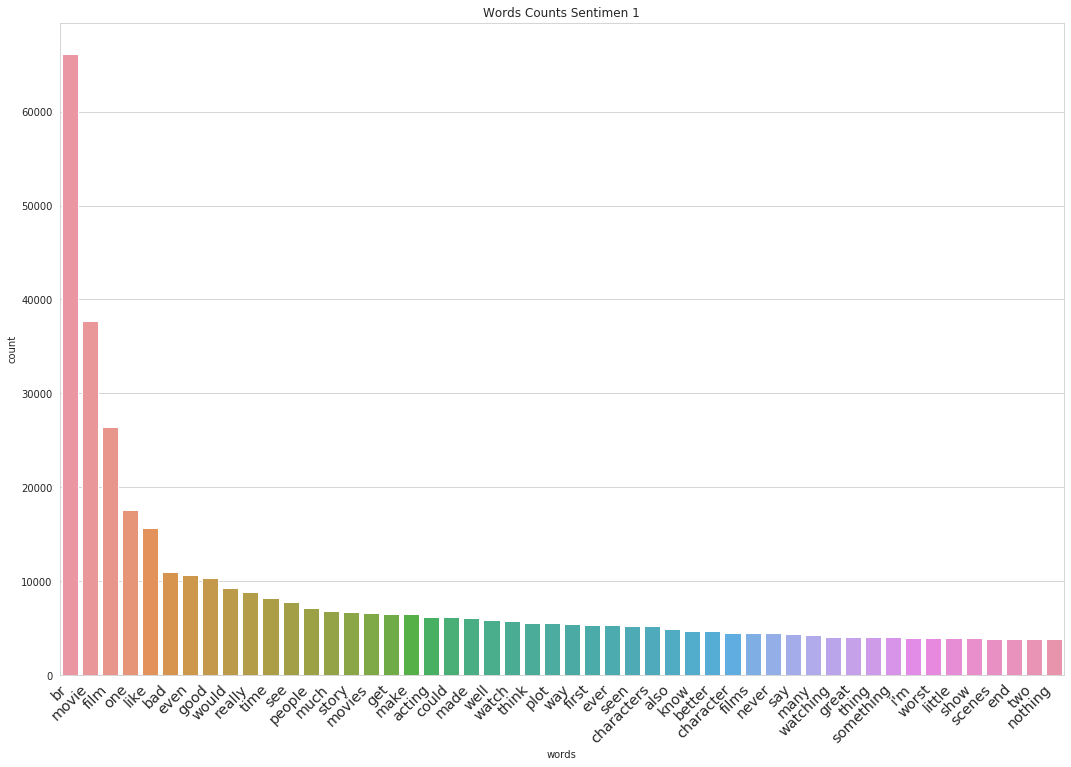

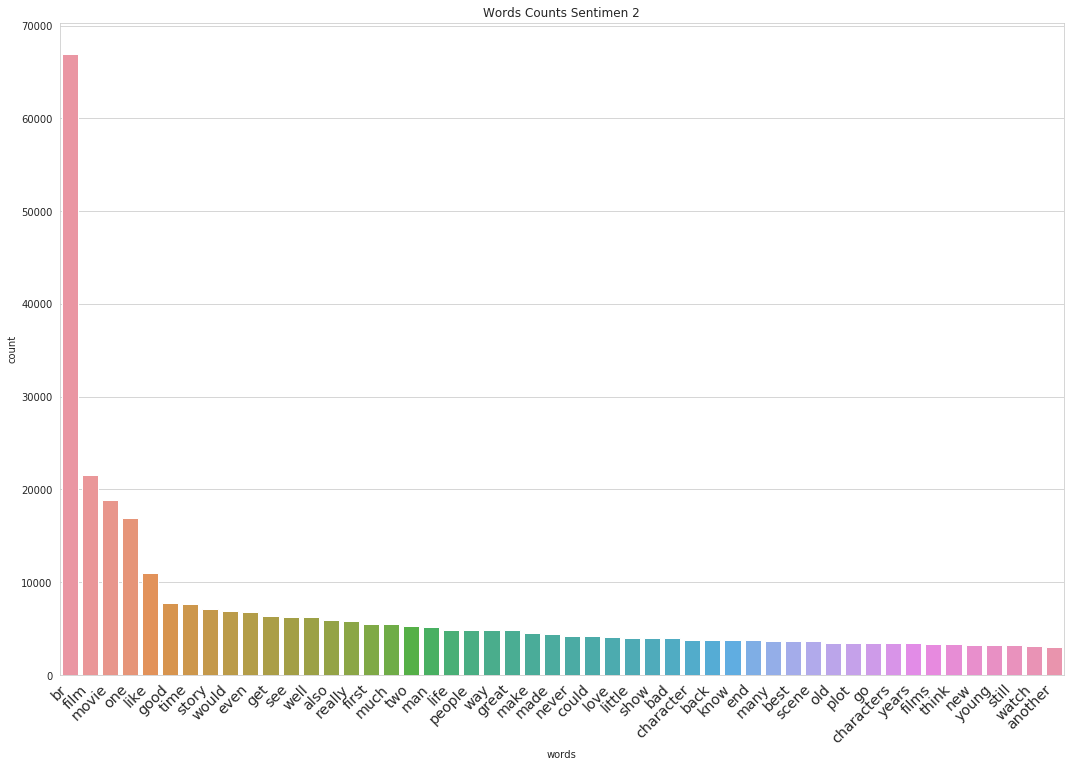

In [86]:
clusters_words_plot(texts=movies_reviews, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

In [18]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=sentiments_reviews,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2]



labels                  cluster_match
0  0       Positive:14202  Negative:3847
1  1       Negative:14621  Positive:3302
2  2       Positive:7496  Negative:6532

#### Visualize

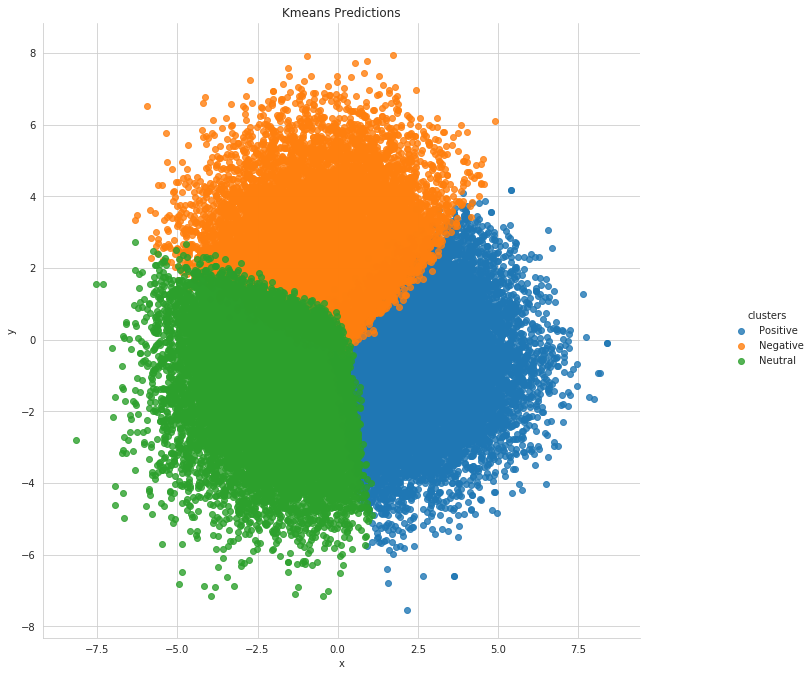

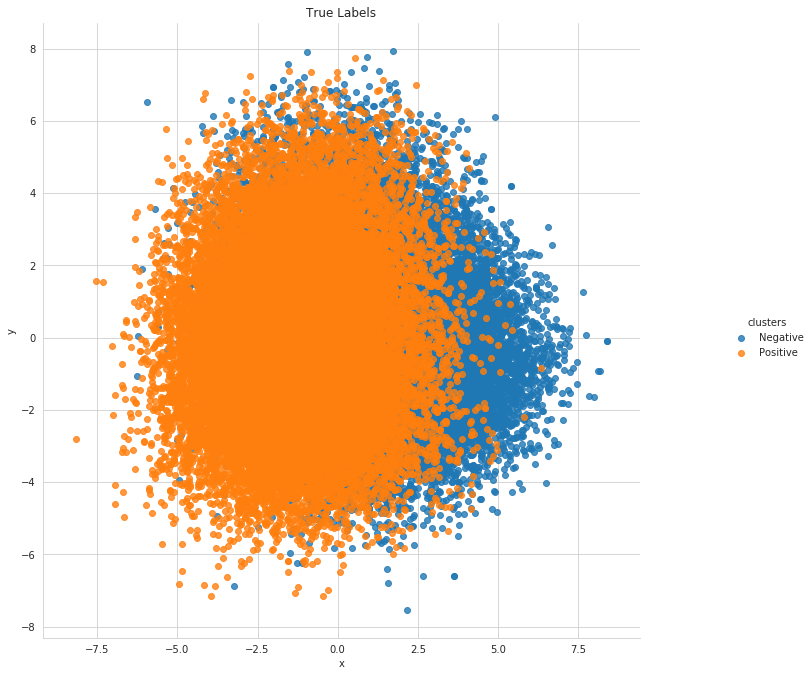

In [19]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative'}

reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=sentiments_reviews, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


#### Samples

In [20]:
show_samples(target_predicitons_class=0, 
              texts=movies_reviews,
             trues=sentiments_reviews, 
             trues_id_sentiment=ID_SENTIMENT,
              predicitons=kmeans_labels,
             predictions_id_sentiment=kmeans_id_sentiment,
              n_samples=3)

Text  ... Prediction Sentiment
0  Way back when, the X-Files was an intelligent, thought-provoking show. A big part of its appeal was that the writers looked to folklore and science for their ideas, tying the plot to the spooky side of real life.<br /><br />I was incredibly wary of the 8th season when it aired. The show had already provided two perfectly good episodes to bow out on ("One Son" and "Requiem"), and the 7th season had seen a sharp rise in episodes that scraped the barrel for ideas that were far-fetched, implausible, or downright silly. But I figured, hey, give it the benefit of a doubt, maybe they're bringing it back because they've got some great ideas lined up.<br /><br />"Roadrunners" really was upsetting. Following "Patience", which at least offered an interesting angle on the vampire folklore that the show had done well to avoid, the episode sees a strange (alien?) parasitic slug with the power of mind control worshipped by a cult of backwoods Christians. Oh, and they think it's the second coming of Christ, but you only find that out in the last couple of minutes. Seriously. There's never *any* attempt to make sense of this, to explain what the slug is, why anything that's happening is happening, or anything. Even in the show's early years - in fact, *especially* then - you could expect a little bit more depth, a bit of background, or if not that then the opposite - a bit of mystery, some uncertainty about what this was all about. <br /><br />It's Scully that really kills it though. You could put up with the silliness of the premise, but to have a character who has been developed over a good 7 years as a rational skeptic transformed into a gullible maverick purely for the sake of advancing the plot is bizarre to watch. You feel like you're watching some godawful teen horror, except that it's a woman well into her thirties throwing herself into the kind of creepy isolated community that she's spent the best part of a decade uncovering the sinister underbelly of, being either outwitted by very stereotypical hicks or utterly indifferent to her own safety. Oh, and by the way, Doggett, the new Mudler, isn't around. Scully just wandered off into the desert to look into a brutal murder on her own without him. He shows up at the end to save the day - I can't even remember why - but apart from that, he's not really in it. Again: seriously.<br /><br />In short, it feels like either a generic script written for another show, or someone's pet movie project which they've been allowed to shove like a mutant leech into the spine of an existing, long-running show at a time when it was at its most vulnerable. It might've worked on a lesser show, where the characters are more archetypal and the audience expects less. But The X-Files had a good thing going, and Scully was one of the strongest and most idiosyncratic TV characters of the 90s. Deciding that you're going to change her personality for the sake of a story that they must've done on Star Trek a good fifty or so times is pointless.  ...  Neutral            
1  Imagine that you are asked by your date what movie you wanted to see, and you remember seeing a rather intriguing trailer about "The Grudge." So, in good faith, you recommend seeing that movie. It is the Halloween season, after all. And it did boffo box office this past weekend, so it must be pretty good...so you go.<br /><br />And you're actually in a state of shock when the movie ends the way it does, and you hear yourself audibly saying, "that can't be the end of the movie...." But, alas, it is. <br /><br />And imagine coming out of the movie theater being embarrassed and ashamed for recommending such a dog of a movie. You think that your date thinks you're a bonehead for suggesting such an atrocity, and your suggestion will certainly end a promising relationship. Actually, it was so bad that both of us cracked up laughing at how bad it was. I see no future for Miss Gellar in the movies, and suggest that she st

### k=4 sentiments

In [0]:
k_sentiments = 4

#### Fit kmeans

In [0]:
kmeans_labels, kmean_model = kmeans(k=k_sentiments, features=np.array(movies_reviews_embeddings))

#### Find Labels

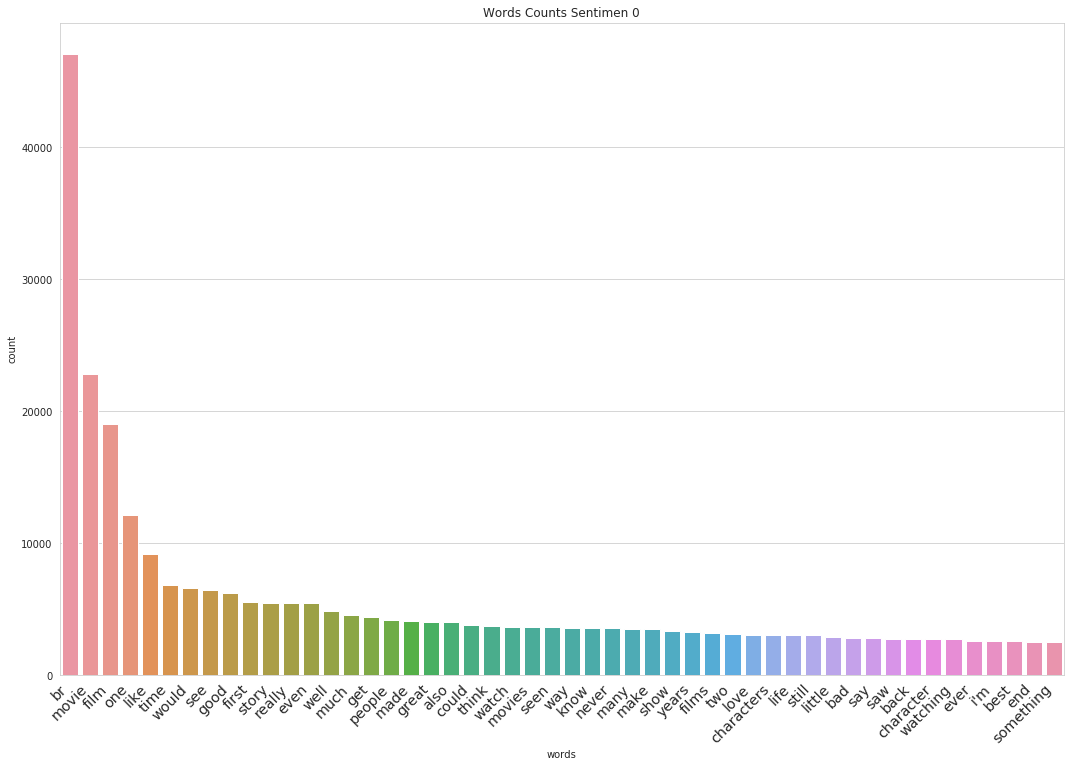

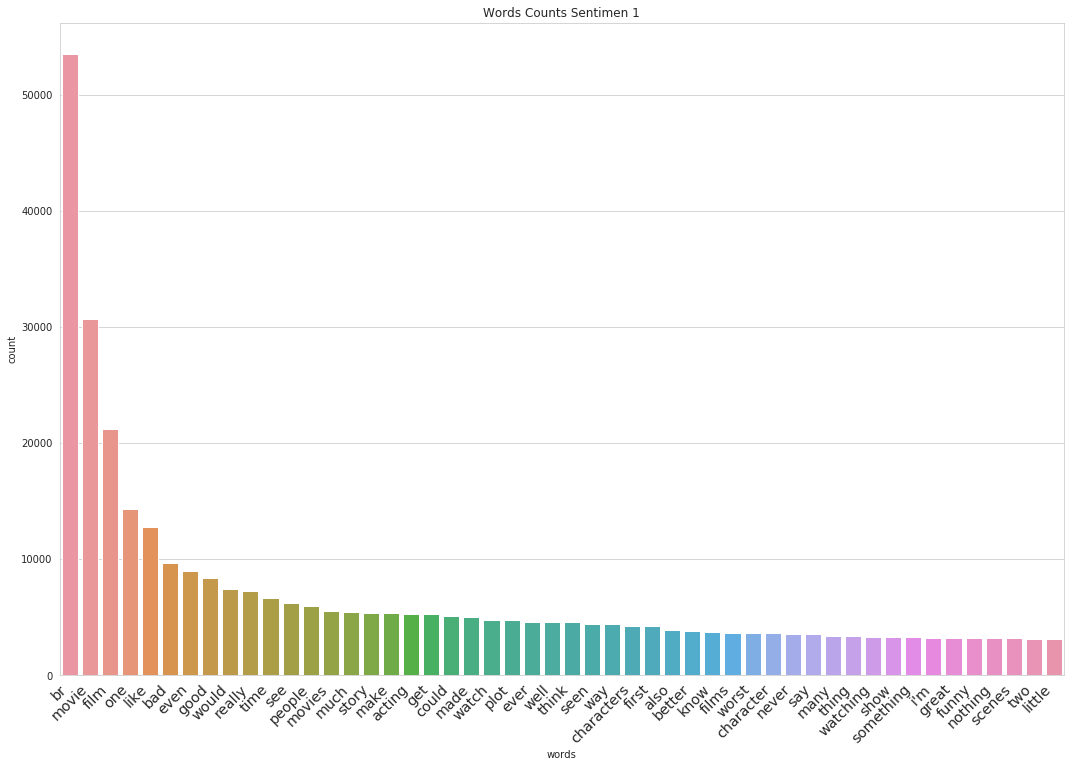

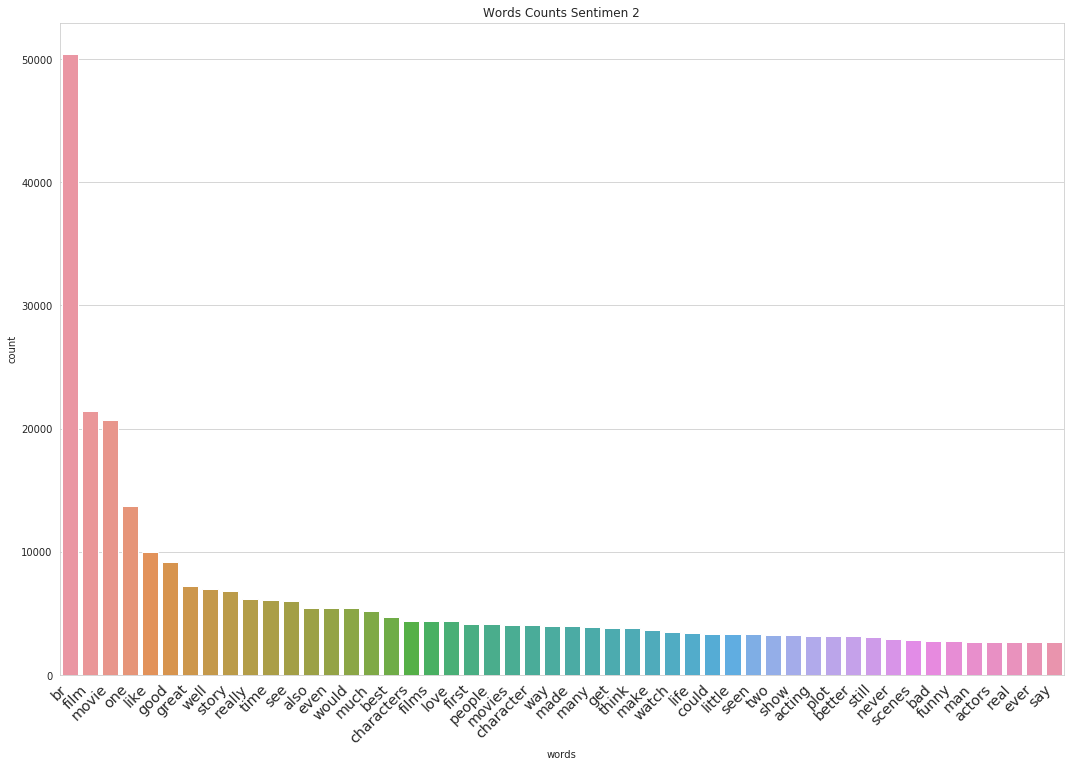

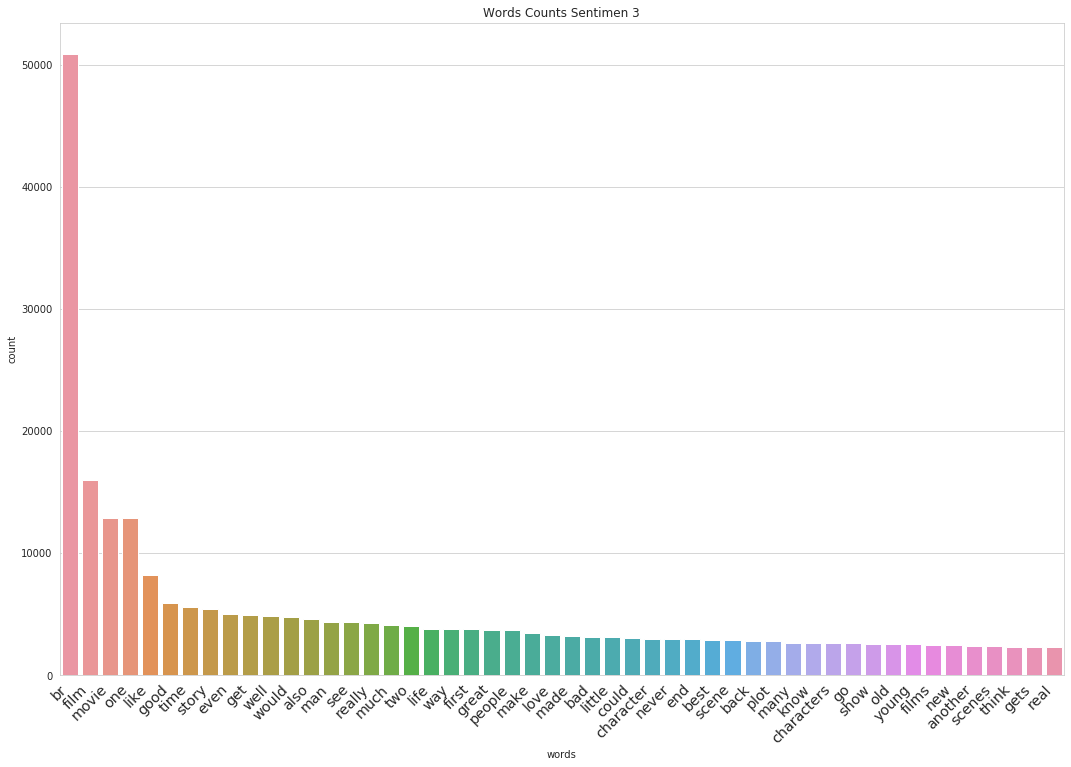

In [92]:
clusters_words_plot(texts=movies_reviews, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

In [23]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=sentiments_reviews,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2, 3]



labels                  cluster_match
0  0       Positive:6142  Negative:4363 
1  1       Negative:12584  Positive:2269
2  2       Positive:10908  Negative:2874
3  3       Positive:5681  Negative:5179

#### Visualize

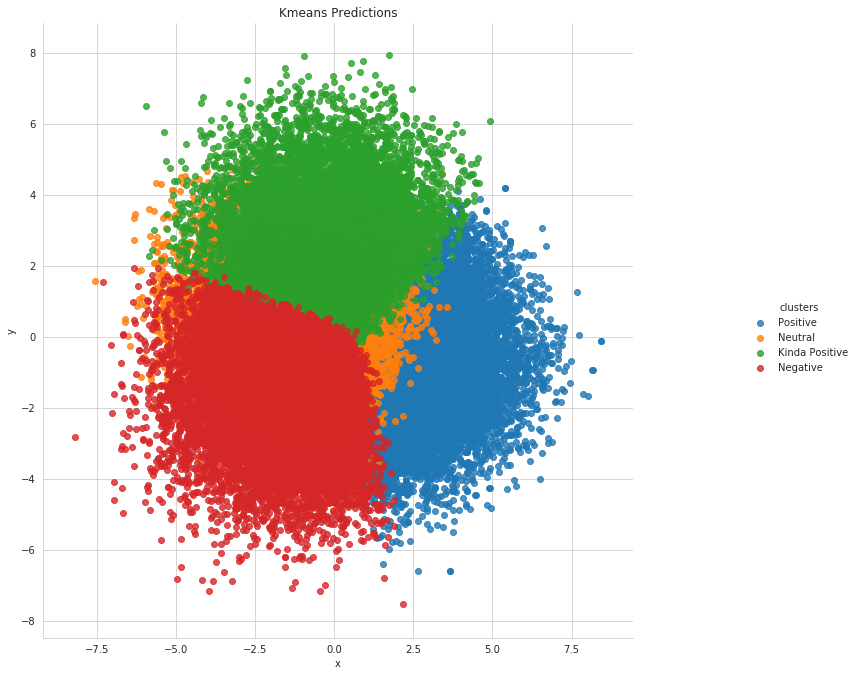

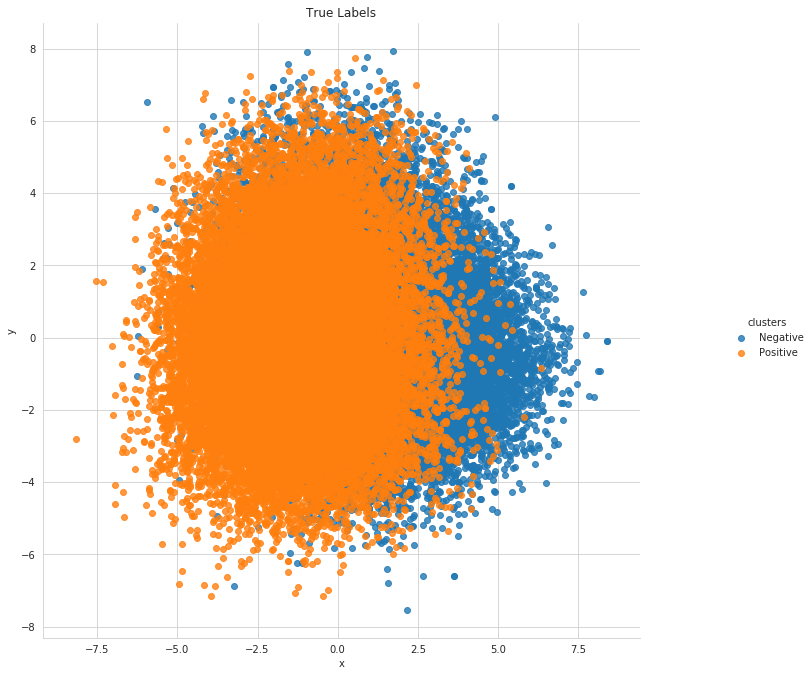

In [24]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative',
                       3:'Kinda Positive'}

reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=sentiments_reviews, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


#### Samples

In [95]:
print(kmeans_id_sentiment)
show_samples(target_predicitons_class=3, 
              texts=movies_reviews,
             trues=sentiments_reviews, 
             trues_id_sentiment=ID_SENTIMENT,
              predicitons=kmeans_labels,
             predictions_id_sentiment=kmeans_id_sentiment,
              n_samples=3)

{0: 'Neutral', 1: 'Positive', 2: 'Negative', 3: 'Kinda Positive'}


Text  ... Prediction Sentiment
0  How could a film dealing with illegal Mexican immigrants being robbed and beaten over the border be dull? Well, "Border Incident" is.<br /><br />No wonder that song and dance man George Murphy's career ended not long after this terrible film came out. Politics was certainly a way out for this future senator who dies a horrible death in this slowly paced film. The film stereotypes the typical Mexican migrant farmer worker as dimwitted and awfully dull.<br /><br />The film only picks up in intensity once the identities of Murphy and Ricardo Montalban have been discovered as federal agents for the U.S. and Mexico respectively.<br /><br />Disappointing at best, we see similar problems in our very own society today.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          ...  Kinda Positive     
1  Curly Sue is a 6 year old with an abundance of hair and a life as a drifter. She and her father, Bill (Jim Belushi), try to survive on the streets by being small time con artists. In Chicago, Bill decides to jump in front of a car in a pricey parking garage while Curly will scream about lawsuits and traction to the intended victim. It happens to be a very upscale lawyer named Grey (Kelly Lynch) who is appropriately appalled at what she has done. Not only do the scammers make some cash, they get to spend the night at Grey's plush apartment. Even then, Grey feels she owes them more so the three of them hang together for a spell. Grey only knows the lucrative law business and nothing about life. Who better to teach her than Bill and Curly, those savvy experts on life's realities? But, all good things must come to an end and there is no life for a legal expert and a couple of con men. Or is there? This is a sweet and funny movie about the unexpected. Curly is certainly as entertaining as Shirley Temple but much edgier, of course. Belushi gives a rare touching performance as the down on his luck con and Lynch is luminous as the snooty but soft touch lawyer. John Hughes, as writer and director, shows us his magic touch once again, as the script is lively and unpredictable. Just watch Curly and Bill take Grey out for a night, with no money, and see the humorous results. Do you long for happy endings, long promised and finally delivered, with a few uncertain moments in between? This is your made-to-order movie.  ...  Kinda Positive     
2  George Sluizer's remake of his own - superior - film is a complete waste of time. Why was it even attempted? Kiefer Sutherland plays Jeff Harriman, whose girlfriend (Sandra Bullock, who only has a small amount of screen time)is abducted at a service station by Barney Cousins (Jeff Bridges). Now, Barney is portrayed as the kind of guy that no one would trust in a month of Sundays - he lopes about like Frankenstein's Monster but without the sympathy, and Bridges' acting is totally awful. Sutherland comes across a little better when his character turns detective with the help of new love interest Rita Baker (Nancy Travis).<br /><br />A major problem with this version of 'The Vanishing' is its obvious need to cater to Hollywood audiences by avoiding the bleak ending of the original film. Here the ending is happy which seems forced and unbelie

### k=5 sentiments

In [0]:
k_sentiments = 5

#### Fit kmeans

In [0]:
kmeans_labels, kmean_model = kmeans(k=k_sentiments, features=np.array(movies_reviews_embeddings))

#### Find Labels

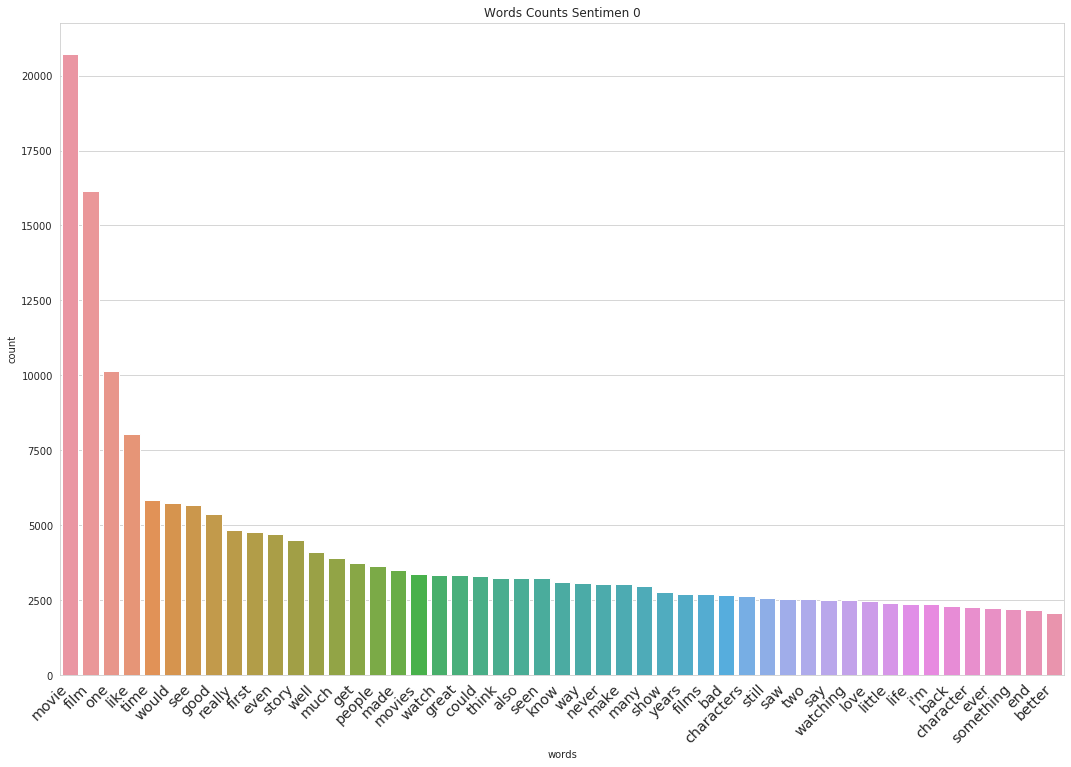

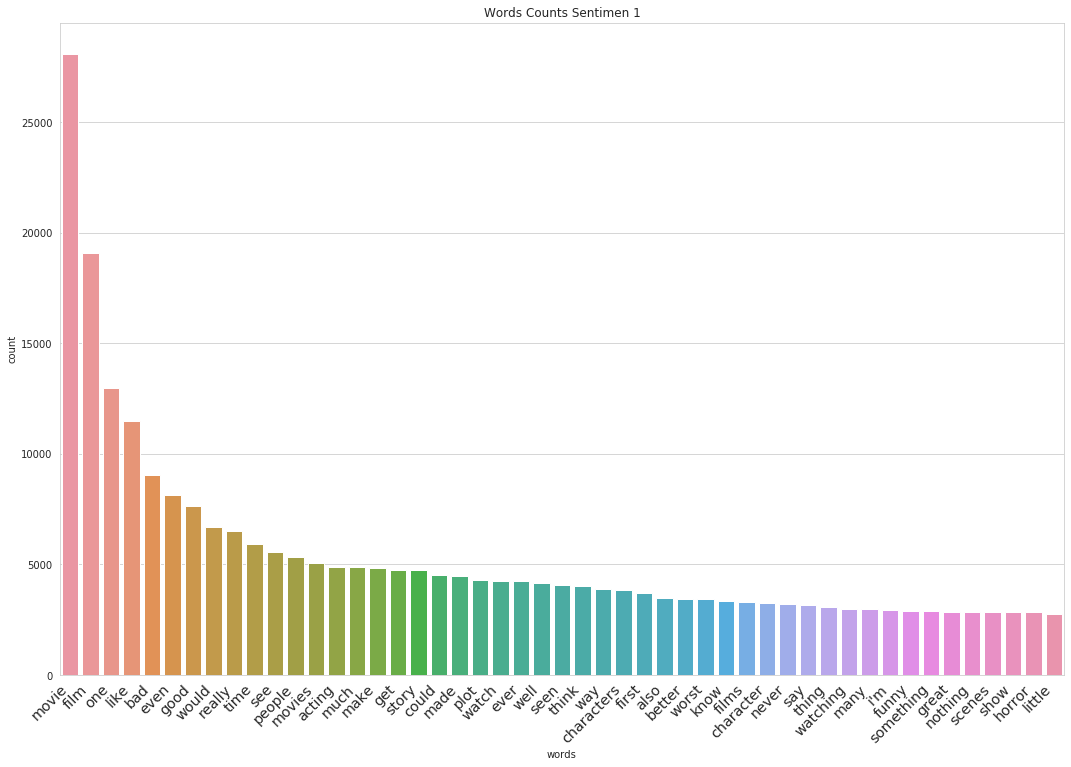

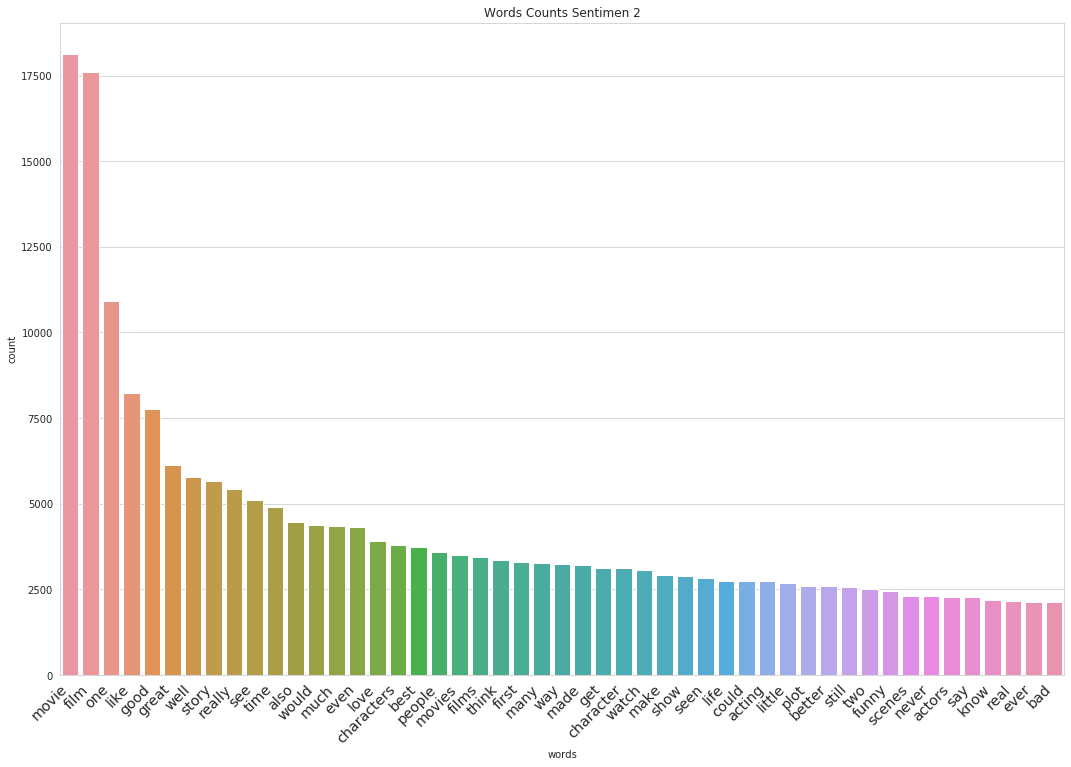

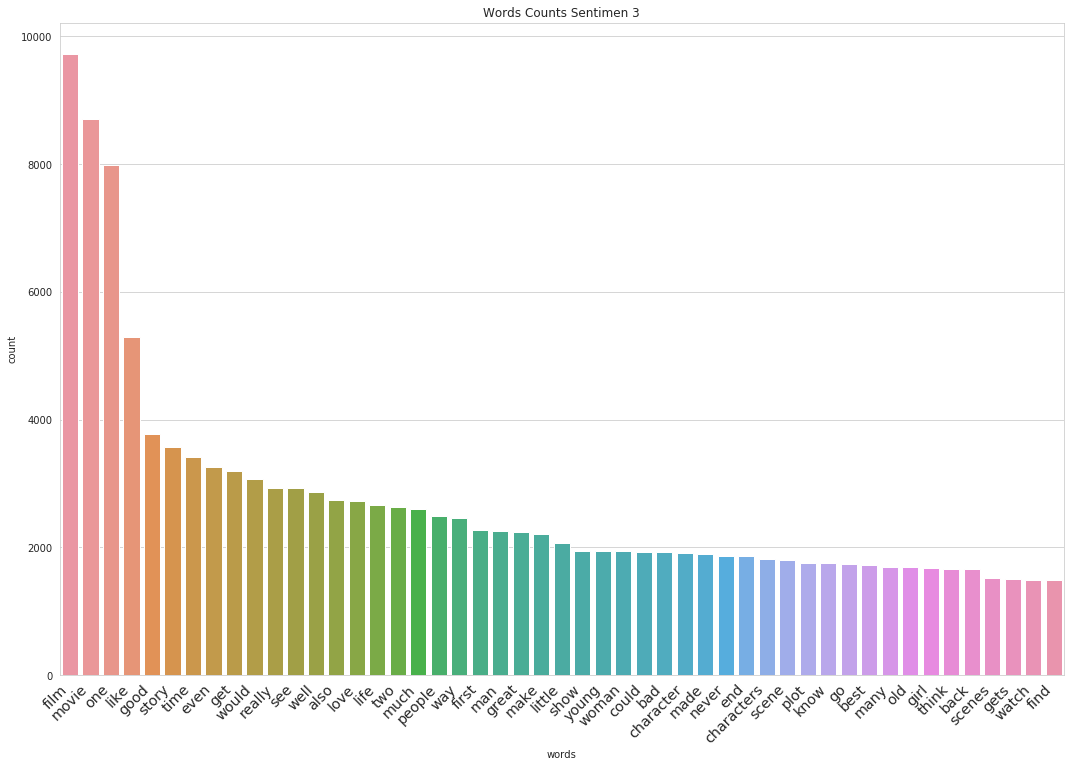

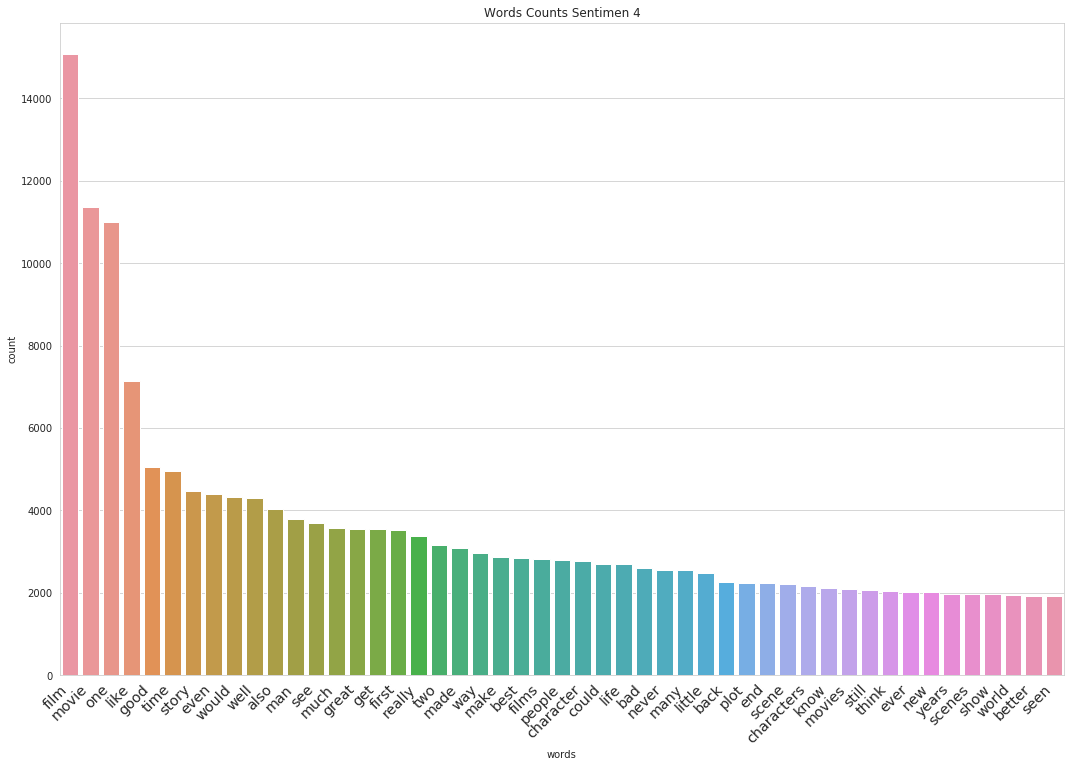

In [99]:
clusters_words_plot(texts=movies_reviews, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

In [27]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=sentiments_reviews,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2, 3, 4]



labels                  cluster_match
0  0       Positive:5002  Negative:3999 
1  1       Negative:11542  Positive:1937
2  2       Positive:9445  Negative:2186 
3  3       Positive:3606  Negative:3495 
4  4       Positive:5010  Negative:3778

#### Visualize

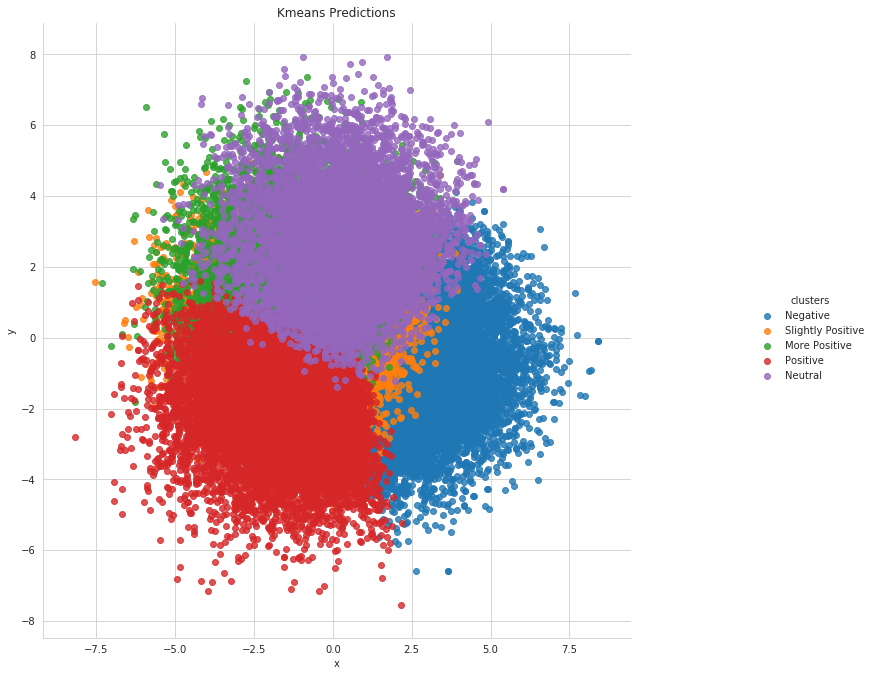

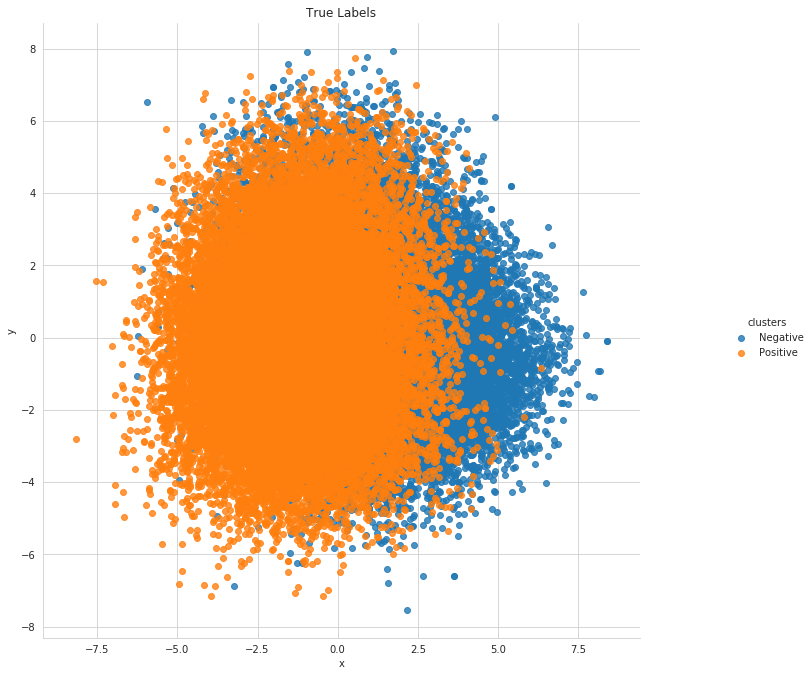

In [28]:
kmeans_id_sentiment = {0:'Slightly Positive',
                        1:'Negative',
                        2:'Positive',
                       3:'Neutral',
                       4:'More Positive'}

reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=sentiments_reviews, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


#### Samples

In [103]:
print(kmeans_id_sentiment)
show_samples(target_predicitons_class=4, 
              texts=movies_reviews,
             trues=sentiments_reviews, 
             trues_id_sentiment=ID_SENTIMENT,
              predicitons=kmeans_labels,
             predictions_id_sentiment=kmeans_id_sentiment,
              n_samples=3)

{0: 'Slightly Positive', 1: 'Negative', 2: 'Positive', 3: 'Neutral', 4: 'More Positive'}


Text  ... Prediction Sentiment
0  Joe Don Baker is an alright to good actor in small roles here and there...he was alright in Goldeneye and made a pretty good Bond villan in The Living Daylights and has appeared in various other movies. One thing he can't do is carry a movie as the lead, which he is in this extremely bad revenge movie set in Malta. Joe Don's partner is killed so he kills the killer's brother and escorts the killer to Italy, but some guys cause the plane to set down in Malta and the killer gets away. The rest of the movie is seeing Joe Don chase the killer here and there, Joe Don getting taken into custody various times, Joe Don torturing a bartendar and being interrupted and so on. The movie is quite bad and you won't find yourself exactly pulling for Joe Don's character. You will be amazed at how many times Joe Don the hero gets taken out by one punch and how incompetent he proves to be. The crowning part of the movie comes when Joe Don chases the killer all over Malta with the killer in a priest robe and then they get in boats and he chases them all around Malta. This movie also features one of the worst closing lines to end a movie ever.                                                                                                                                                                                                                                                                                                                                                                                                                                                        ...  More Positive      
1  <br /><br />Emilio Estevez takes the wonderful play HOMEFRONT and makes it into an engaging movie.<br /><br />THE WAR AT HOME has an exceptionally strong cast -- all seemingly digging deep into their characters. The acting here is TOP NOTCH!<br /><br />Credit must also go to director Emilio Estevez. The visual transitions between past and present were ultra smooth. The sound effects during the battle scenes were chilling and effectively added to the tension.<br /><br />Remove all of the Viet Nam elements from the story, and still left would be interesting characters wrestling with the good and bad of the full range of family dynamics. (A viewer might see this point more clearly by keeping in mind the "discovering the old photo" scene from the beginning as the rest of the movie is watched).<br /><br />As a movie, I found THE WAR AT HOME to be more direct and to the point than BORN ON THE 4TH OF JULY. A fine effort -- almost a 10.<br /><br />                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ...  More Positive      
2  I have some great memories watching "Robin of Sherwood" on TV as a kid (but I think I only saw Michael Praed´s episodes, by some reason). And recently my brother bought the new released DVD-boxes of the complete series. It was great to see it again, and it is the best of all the Robin Hood movies and TV-series. The cast is great, and the locations mixed with Clannad´s music adds this very special feeling. I personally think that Praed is the best of the two Robins, but Jason Connery was a great choice to continue the series with. Ray Winstone, Nicolas Grace and Robert Addie is terrific in their roles as Will Scarlet, The Sheriff of Nottingham and Guy of Gisburne. It´s a pity that a fourth season never got made, and I´ve also heard that th

## Custom Samples

In [104]:
# use last trained model
custom_sample(text="I am meh!", 
              model=kmean_model,
              prediction_id_label=kmeans_id_sentiment)

Batches: 100%|██████████| 1/1 [00:00<00:00, 59.17it/s]


'More Positive'

# Yelp Reviews

## Dataset

In [0]:
yelp_reviews_texts, yelp_reviews_stars = read_yelp_reviews('yelp_academic_dataset_review.pickle')

## Embeddings

In [0]:
yelp_reviews_embeddings = context_embedding(text=yelp_reviews_texts, name_of_model=PRETRAINED_MODEL, batch_size=300, use_device="cuda")

Batches:  40%|███▉      | 2068/5231 [34:06<30:19:44, 34.52s/it]

# Friends TV Series

## Dataset

In [54]:
CHARACTERS_NAMES = {0:'joey', 1:'chandler', 3:'monica', 4:'ross', 5:'rachel', 6:'phoebe'}

tmp_df = pd.read_csv('friends_combined.csv')

dialogues_acts = tmp_df['dialogues_acts'].values
characters_labels = tmp_df['labels'].values

len(characters_labels)

95314

## Embeddings

In [48]:
dialogues_acts_embeddings = context_embedding(text=dialogues_acts, name_of_model=PRETRAINED_MODEL, batch_size=500, use_device="cuda")

Batches: 100%|██████████| 191/191 [01:38<00:00,  1.72s/it]


## Find Best K means

In [0]:
max_n_cluster = 10

### Elbow Method

For n_clusters = 2 Distortion is : 17872176.0
For n_clusters = 3 Distortion is : 17093080.0
For n_clusters = 4 Distortion is : 16636402.0
For n_clusters = 5 Distortion is : 16247783.0
For n_clusters = 6 Distortion is : 15882580.0
For n_clusters = 7 Distortion is : 15665275.0
For n_clusters = 8 Distortion is : 15485349.0
For n_clusters = 9 Distortion is : 15351855.0


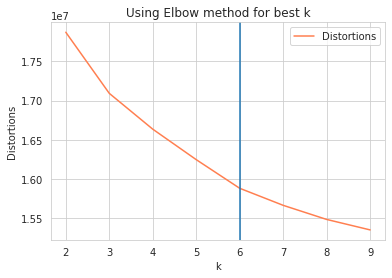

In [50]:
best_kmeans_elbow(features=dialogues_acts_embeddings, n_clusters=max_n_cluster, verbose=True)

### Best K model

In [0]:
best_k = 6
best_kmeans_labels, _ = kmeans(k=best_k, features=dialogues_acts_embeddings)

### PCA Visualize

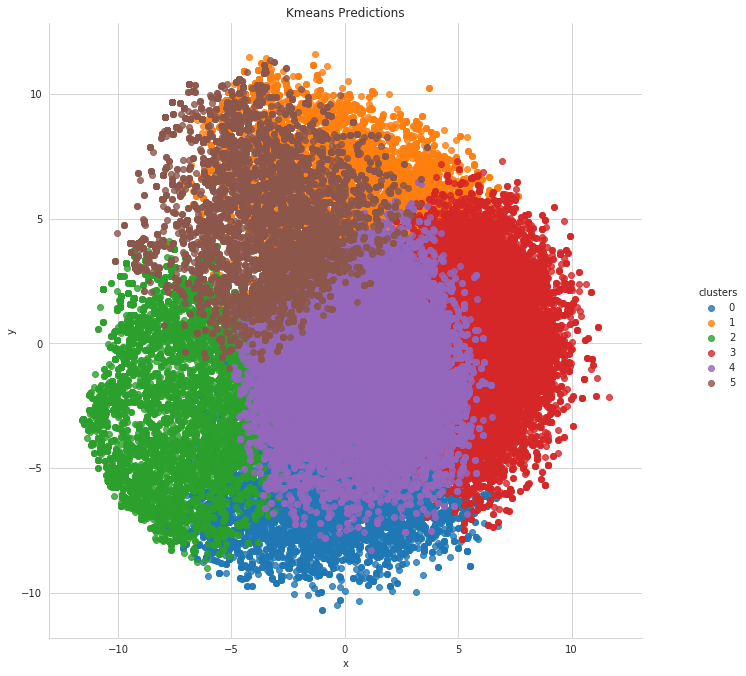

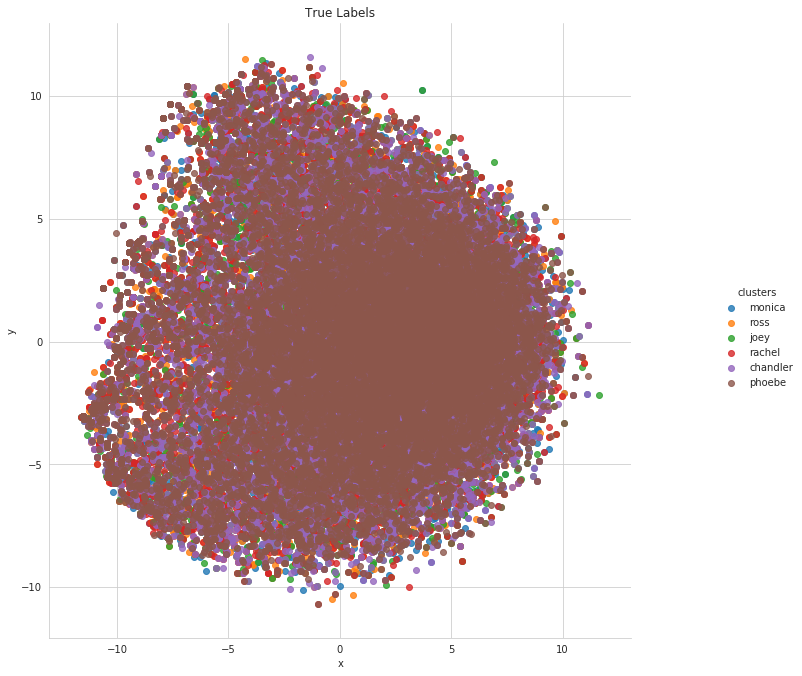



Found labels: [0, 1, 2, 3, 4, 5]



labels                                                               cluster_match
0  0       chandler:1894  rachel:1856  monica:1841  ross:1836  joey:1705  phoebe:1699
1  1       rachel:1838  ross:1833  chandler:1791  monica:1771  joey:1648  phoebe:1517
2  2       ross:2475  rachel:2471  chandler:2311  monica:2309  joey:2199  phoebe:2158
3  3       chandler:4503  rachel:4348  ross:4328  monica:4327  joey:4224  phoebe:4053
4  4       ross:4473  rachel:4462  chandler:4455  monica:4439  joey:4218  phoebe:4022

In [55]:
reduced_features = pca_reduction(features=dialogues_acts_embeddings, 
                                 labels_values=best_kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=None,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=dialogues_acts_embeddings, 
                                 labels_values=characters_labels, 
                                 n_components=2, 
                                 label_decoder=CHARACTERS_NAMES,
                                 title='True Labels')

print('\n')
matching_df = predictions_overlap(model_predicitons=best_kmeans_labels, 
                                  true_predicitons=characters_labels,
                                  label_decoder=CHARACTERS_NAMES)
matching_df.head()

## k personas

In [69]:
k_personas = 2
kmeans_labels, kmean_model = kmeans(k=k_personas, features=dialogues_acts_embeddings)
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=characters_labels,
                                  label_decoder=CHARACTERS_NAMES)
matching_df.head()

Found labels: [0, 1]



labels                                                                   cluster_match
0  0       chandler:10466  rachel:10301  ross:10232  monica:10151  joey:9713  phoebe:9278
1  1       ross:6162  rachel:6154  monica:5952  chandler:5861  joey:5585  phoebe:5459

### Fit kmeans

In [0]:
kmeans_labels, kmean_model = kmeans(k=k_personas, features=dialogues_acts_embeddings)

### Find Labels

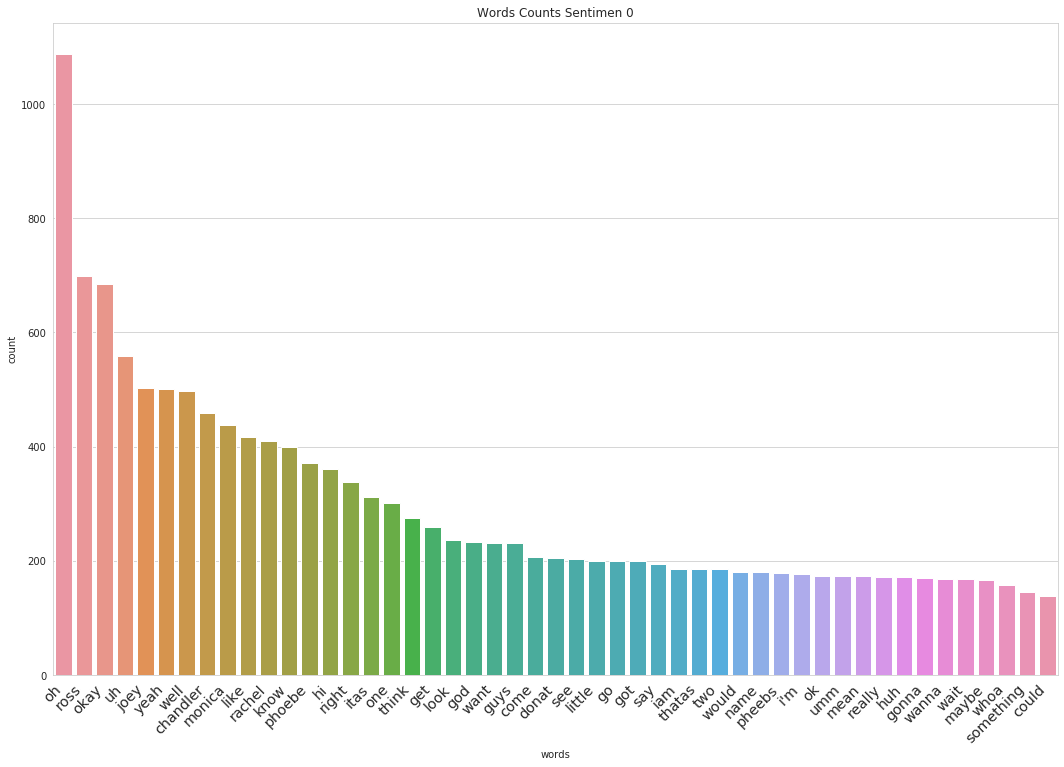

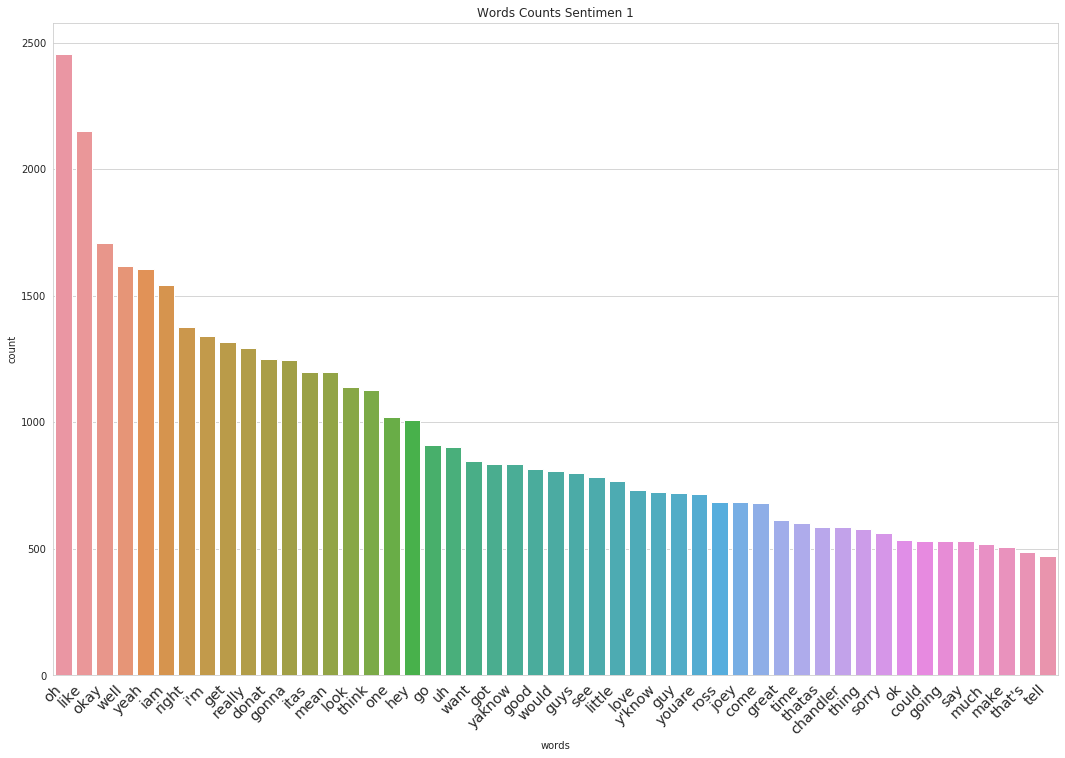

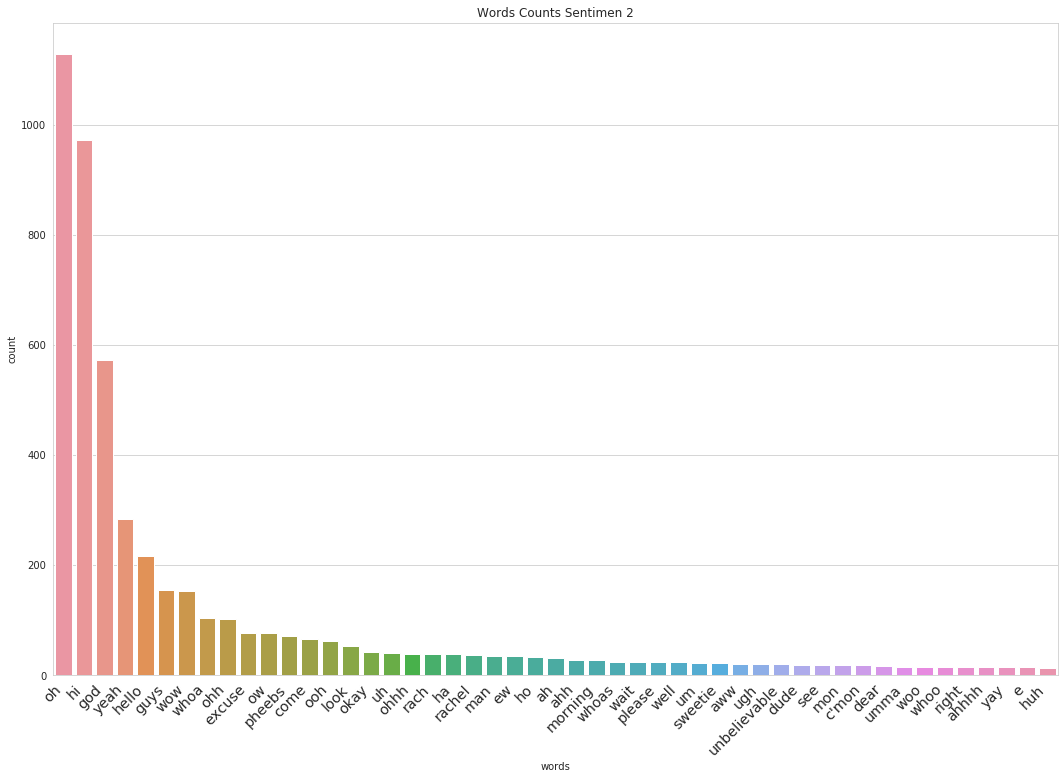

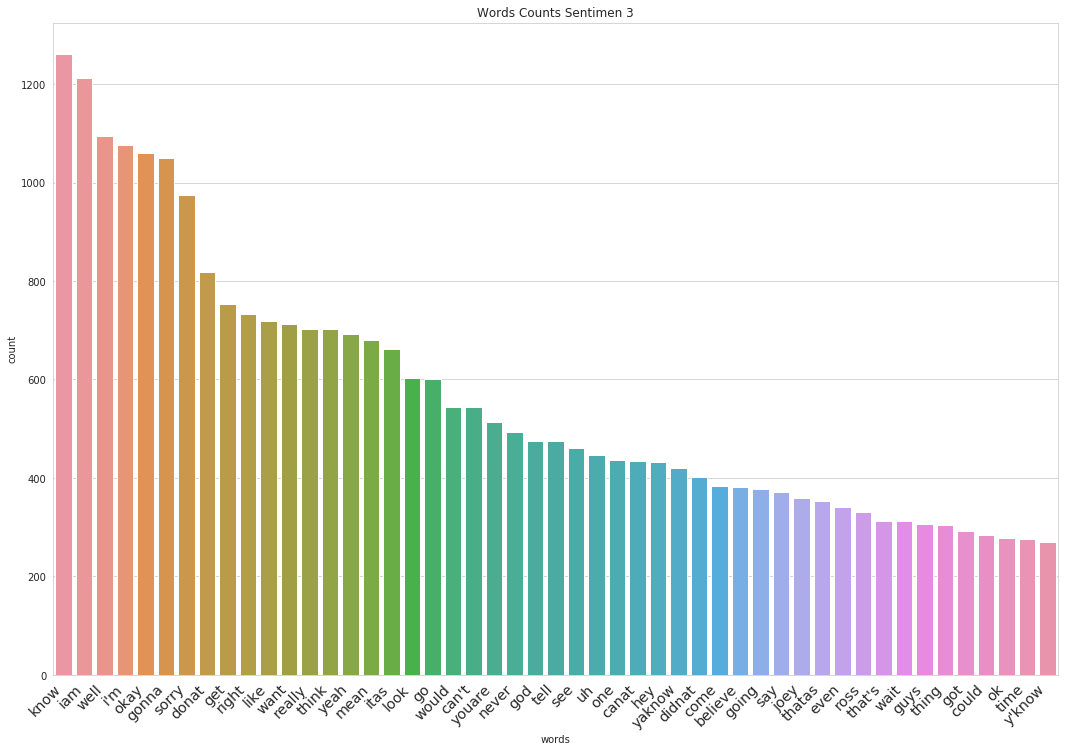

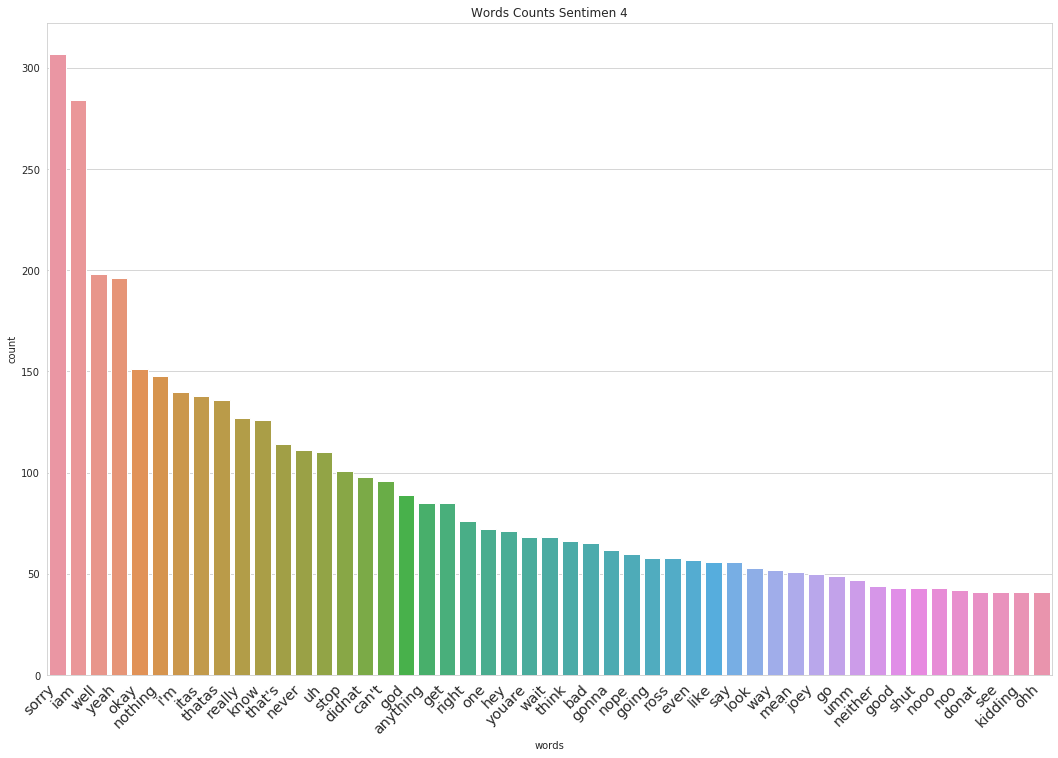

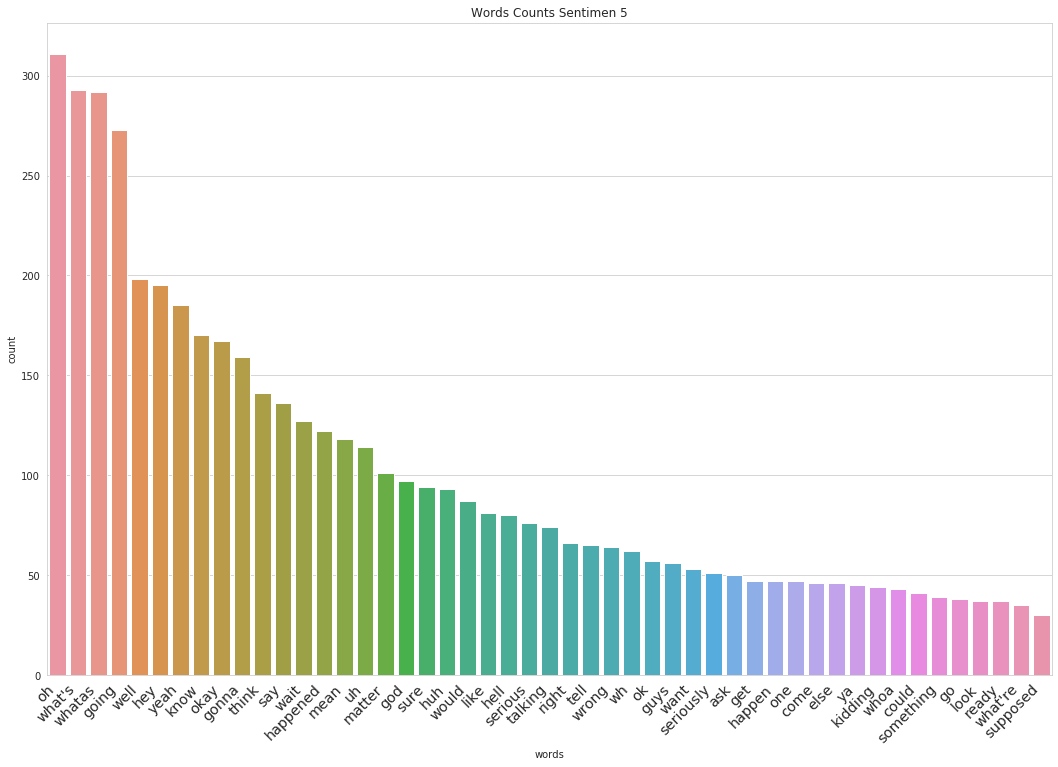

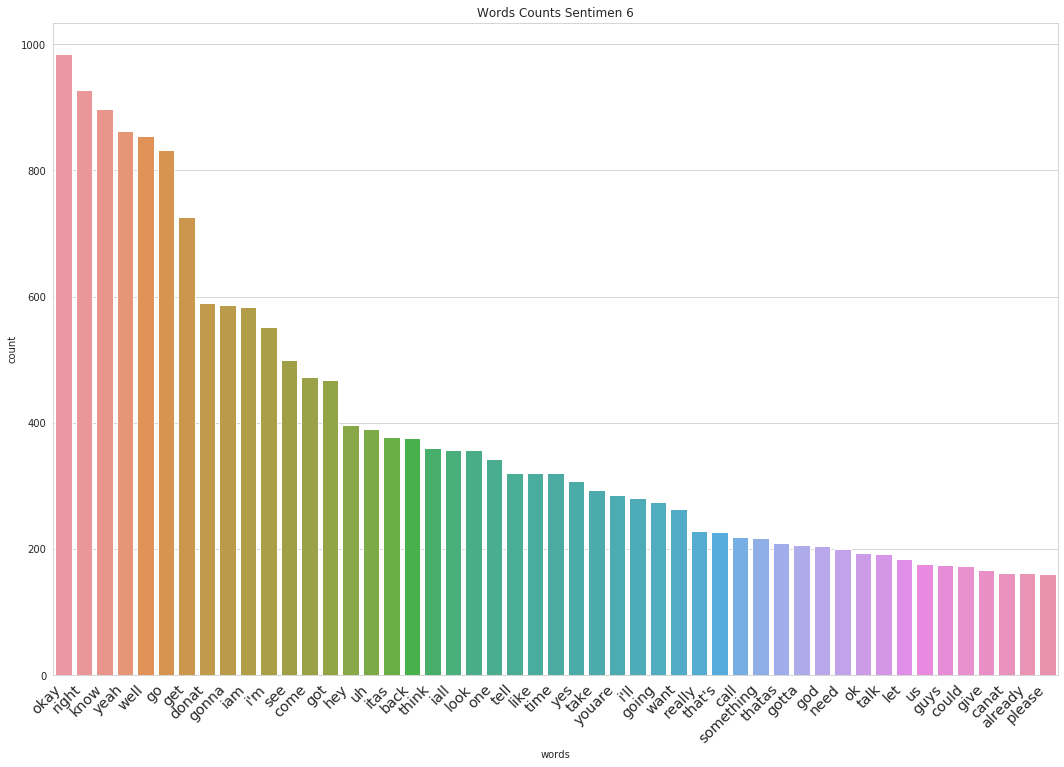

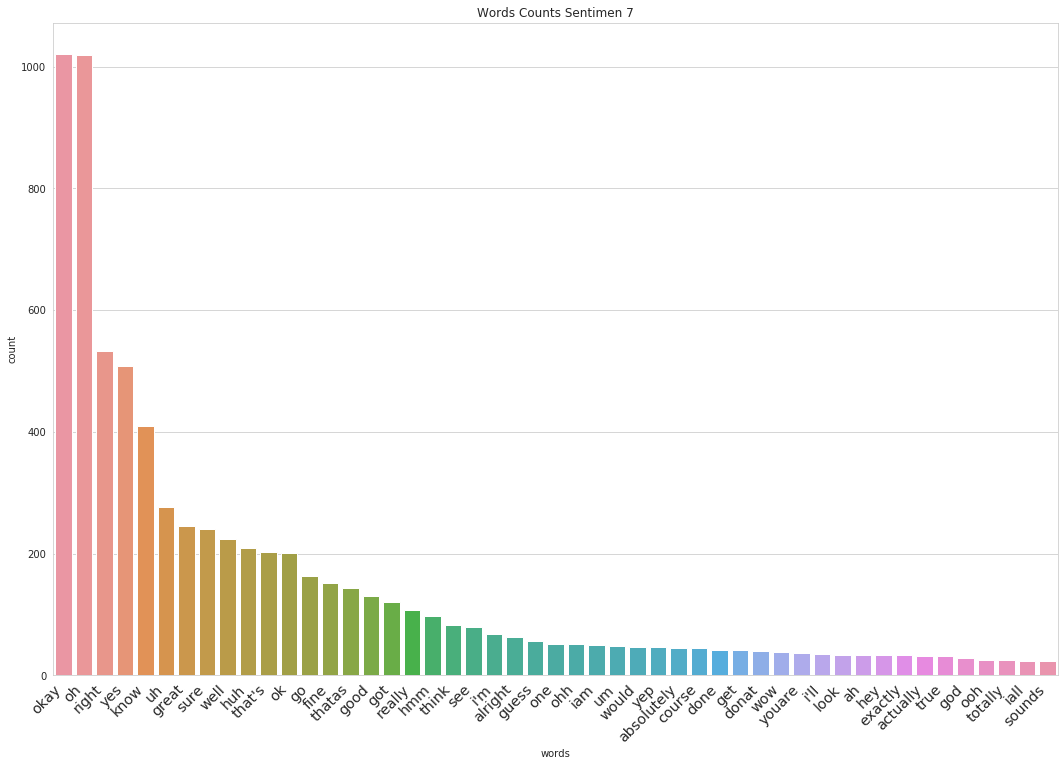

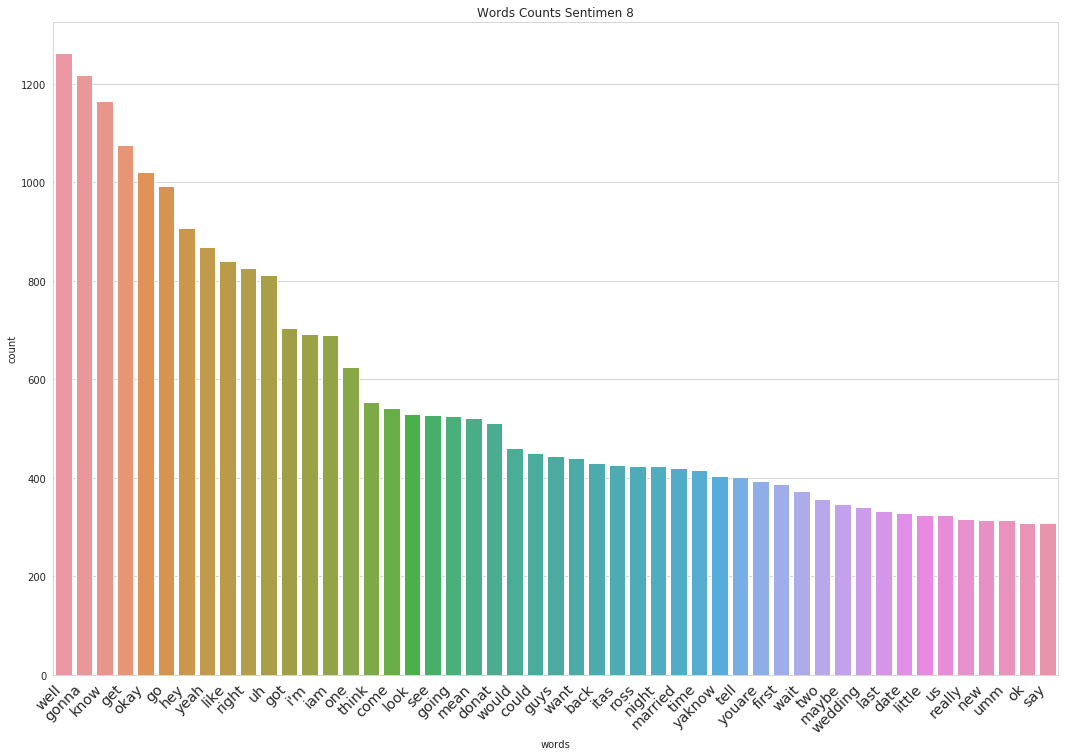

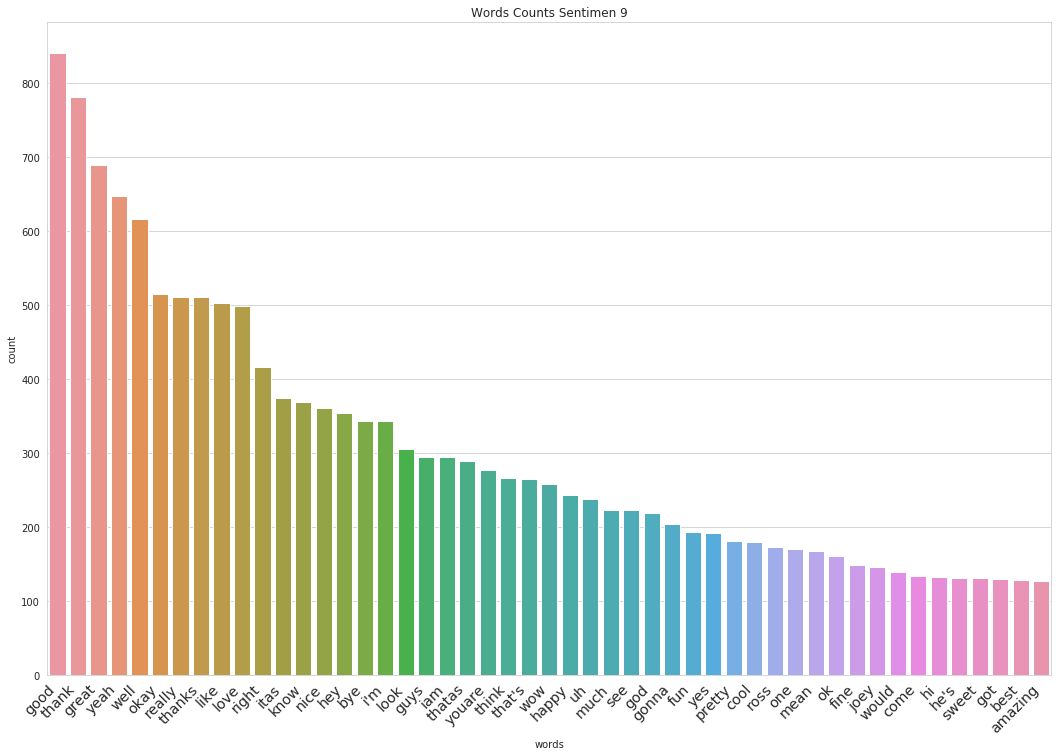

In [66]:
clusters_words_plot(texts=dialogues_acts, 
                    labels=kmeans_labels, 
                    n_sentiments=k_personas, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

In [65]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=characters_labels,
                                  label_decoder=CHARACTERS_NAMES)
matching_df.head()

Found labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



labels                                                               cluster_match
0  0       ross:2243  chandler:2186  rachel:2179  monica:2134  joey:2095  phoebe:2048
1  1       chandler:2426  joey:2367  monica:2360  ross:2355  rachel:2333  phoebe:2237
2  2       rachel:1082  ross:1080  chandler:1023  joey:1010  monica:1004  phoebe:973 
3  3       chandler:2138  ross:2115  rachel:2062  monica:1991  joey:1925  phoebe:1857
4  4       rachel:907  monica:876  ross:872  chandler:841  joey:821  phoebe:727

### Visualize

In [0]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative',
                       3:'Kinda Positive'}

reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(movies_reviews_embeddings), 
                                 labels_values=sentiments_reviews, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')
